In [1]:
import pandas as pd
import pickle
import ledapy
import tqdm
import datetime
import neurokit2 as nk
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
subject_id = 'c1s01'
cgm_data = pd.read_pickle('../../dataset/processed/c1s01/1.pkl')
# cgm_data = pd.read_pickle('../../dataset/processed/c1s01/1863.pkl')

cgm_idx = cgm_data['Index']
cgm_timestamp = cgm_data['Timestamp']
cgm_glucose = cgm_data['glucose']

In [3]:
print(cgm_data)

{'Index': 19135.0, 'Timestamp': Timestamp('2022-06-08 13:38:47'), 'glucose': 130.0, 'zephyr': {'Accel': {'Time': array(['2022-06-08T13:33:48.001000000', '2022-06-08T13:33:48.011000000',
       '2022-06-08T13:33:48.021000000', ...,
       '2022-06-08T13:38:46.971000000', '2022-06-08T13:38:46.981000000',
       '2022-06-08T13:38:46.991000000'], dtype='datetime64[ns]'), 'Vertical': array([1968, 1968, 1968, ..., 1978, 1978, 1977]), 'Lateral': array([2040, 2041, 2041, ..., 2020, 2018, 2020]), 'Sagittal': array([2057, 2056, 2060, ..., 2028, 2027, 2027])}, 'Breathing': {'Time': array(['2022-06-08T13:33:48.001000000', '2022-06-08T13:33:48.041000000',
       '2022-06-08T13:33:48.081000000', ...,
       '2022-06-08T13:38:46.881000000', '2022-06-08T13:38:46.921000000',
       '2022-06-08T13:38:46.961000000'], dtype='datetime64[ns]'), 'BreathingWaveform': array([6426769, 6422721, 6418134, ..., 6346030, 6344843, 6344520])}, 'ECG': {'Time': array(['2022-06-08T13:33:48.001000000', '2022-06-08T13:33:4

## ECG Data

In [4]:
ecg_data = cgm_data['zephyr']['ECG']
summary_data = cgm_data['zephyr']['Summary']

In [5]:
fs = 250
ecg_clean = nk.ecg_clean(ecg_data['EcgWaveform'], sampling_rate=fs)
_, rpeaks = nk.ecg_peaks(ecg_clean, sampling_rate=fs, correct_artifacts=True)
r_peaks = np.unique(rpeaks['ECG_R_Peaks'])

window_size = 3 * fs

extracted_ecg = []
for peak in tqdm.tqdm(r_peaks):
    start_idx = peak - window_size//2
    end_idx = start_idx + window_size
    try:
        start_t = ecg_data['Time'][start_idx]
        end_t = ecg_data['Time'][end_idx]
        beat_ecg = ecg_clean[start_idx:end_idx]

        if beat_ecg.shape[0] == 0:
            continue
        
        summary_window = (summary_data['Time'] >= start_t) & (summary_data['Time'] < end_t)
        avg_HRConfidence = summary_data["HRConfidence"][summary_window].mean()
        avg_ECGNoise = summary_data["ECGNoise"][summary_window].mean()

        extracted_ecg.append({
            'ecg': beat_ecg,
            'start_t': start_t,
            'end_t': end_t,
            'glucose': cgm_glucose,
            'CGM_idx': cgm_idx,
            'Timestamp': cgm_timestamp,
            'HRConfidence': avg_HRConfidence,
            'ECGNoise': avg_ECGNoise
        })
    except:
        pass

extracted_ecg = pd.DataFrame(extracted_ecg)


100%|██████████| 255/255 [00:00<00:00, 50447.98it/s]


In [6]:
clean_extracted_ecg = extracted_ecg[extracted_ecg['HRConfidence'] >= 100 & (extracted_ecg['ECGNoise'] <= 0.001)]
clean_extracted_ecg = clean_extracted_ecg.sort_values('start_t')
print(clean_extracted_ecg)

                                                   ecg  \
0    [-0.5536664503366423, -0.5529193450136825, -0....   
1    [0.2507720477821974, 0.2110537891060886, 0.291...   
2    [0.5164608871892366, 0.6336743022948164, 0.670...   
3    [0.15310806717974929, 0.07163644514615337, 0.1...   
4    [-0.43164624817753827, -0.3539217717117318, -0...   
..                                                 ...   
248  [-0.15484861673655276, -0.15520850762109314, -...   
249  [-0.1608378979952133, -0.08161128128230112, 0....   
250  [-0.4327256455177434, -0.23244620861418003, 0....   
251  [-0.1585084115636673, -0.15687469333883983, -0...   
252  [-0.38744982947792783, -0.3456216573164567, -0...   

                    start_t                   end_t  glucose  CGM_idx  \
0   2022-06-08 13:33:49.597 2022-06-08 13:33:52.597    130.0  19135.0   
1   2022-06-08 13:33:50.917 2022-06-08 13:33:53.917    130.0  19135.0   
2   2022-06-08 13:33:52.285 2022-06-08 13:33:55.285    130.0  19135.0   
3   2022-06

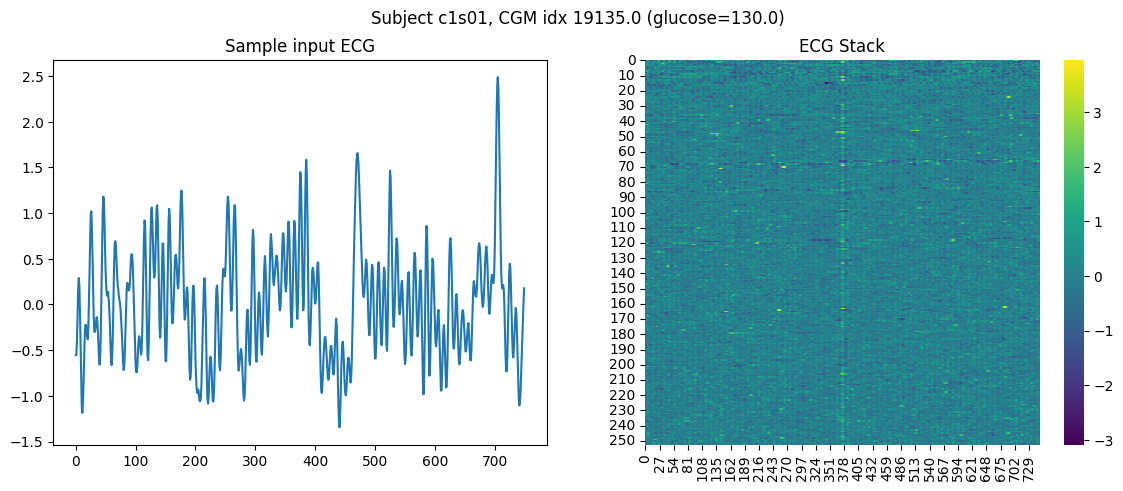

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
# for i in range(clean_extracted_ecg.shape[0]):
axs[0].plot(clean_extracted_ecg['ecg'][0])
axs[0].set_title('Sample input ECG')

heat_map = np.zeros((clean_extracted_ecg.shape[0], clean_extracted_ecg['ecg'][0].shape[0]))
for i in range(clean_extracted_ecg.shape[0]):
    heat_map[i, :] = clean_extracted_ecg['ecg'][i]

sns.heatmap(heat_map, ax=axs[1], cmap='viridis')
axs[1].set_title('ECG Stack')

fig.suptitle('Subject {}, CGM idx {} (glucose={})'.format(subject_id, cgm_idx, cgm_glucose))
plt.show()



## PPG Data

In [8]:
ppg_data = cgm_data['e4']['BVP']

In [9]:
ppg_fs = 64
ppg_clean = nk.ppg_clean(ppg_data['BVP'], sampling_rate=ppg_fs)

In [10]:
window_size = 30 * ppg_fs
overlap_ratio = 0.5

extracted_ppg = []
for i in tqdm.tqdm(range(0, ppg_data['Time'].shape[0], int(window_size * overlap_ratio))):
    try:
        start_idx = i
        end_idx = start_idx + window_size
        start_t = ppg_data['Time'][start_idx]
        end_t = ppg_data['Time'][end_idx]
        window_ppg = ppg_clean[start_idx:end_idx]

        extracted_ppg.append({
            'ppg': window_ppg,
            'start_t': start_t,
            'end_t': end_t,
            'glucose': cgm_glucose,
            'CGM_idx': cgm_idx,
            'Timestamp': cgm_timestamp,
        })
    except:
        pass

extracted_ppg = pd.DataFrame(extracted_ppg)

100%|██████████| 10/10 [00:00<00:00, 89430.79it/s]


In [11]:
print(extracted_ppg)

                                                 ppg  \
0  [-2.19015319728266, -2.567801574405306, -2.424...   
1  [-21.495209432337816, -20.663056632781533, -20...   
2  [-123.61685729944185, -127.96302655371395, -11...   
3  [167.2040947228721, 176.64675667445076, 186.66...   
4  [-177.09340347825838, -126.81653072774407, -50...   
5  [-46.677833118802354, -40.486733395220725, -35...   
6  [158.16061066221607, 175.75949477929578, 188.6...   
7  [16.451954747988353, 1.706721383931864, -14.51...   

                     start_t                      end_t  glucose  CGM_idx  \
0 2022-06-08 13:33:48.015625 2022-06-08 13:34:18.015625    130.0  19135.0   
1 2022-06-08 13:34:03.015625 2022-06-08 13:34:33.015625    130.0  19135.0   
2 2022-06-08 13:34:18.015625 2022-06-08 13:34:48.015625    130.0  19135.0   
3 2022-06-08 13:34:33.015625 2022-06-08 13:35:03.015625    130.0  19135.0   
4 2022-06-08 13:34:48.015625 2022-06-08 13:37:56.781250    130.0  19135.0   
5 2022-06-08 13:35:03.015625 2022

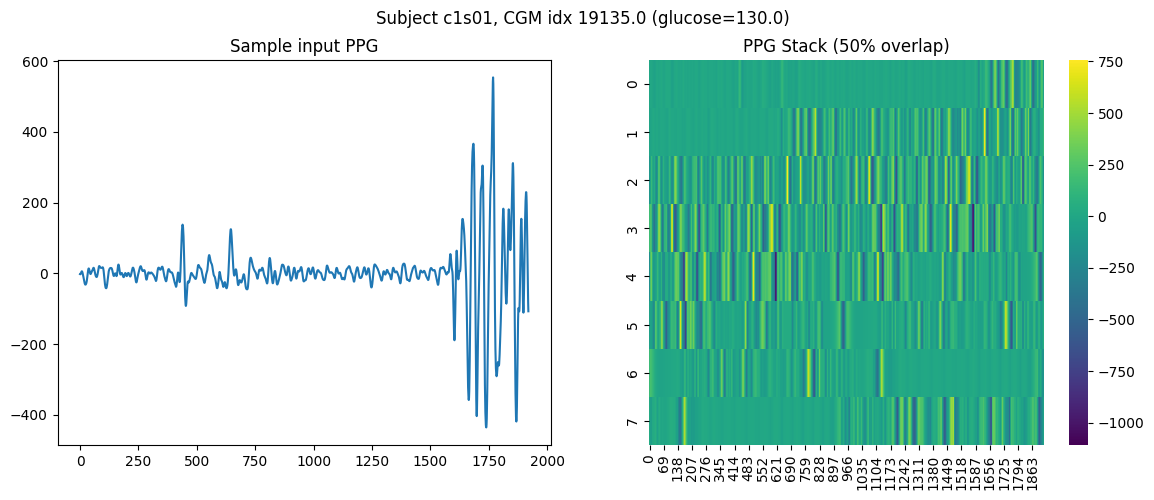

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
# for i in range(extracted_ppg.shape[0]):
#     axs[0].plot(extracted_ppg['ppg'][i])
axs[0].plot(extracted_ppg['ppg'][0])
axs[0].set_title('Sample input PPG')

heat_map = np.zeros((extracted_ppg.shape[0], extracted_ppg['ppg'][0].shape[0]))
for i in range(extracted_ppg.shape[0]):
    heat_map[i, :] = extracted_ppg['ppg'][i]

sns.heatmap(heat_map, ax=axs[1], cmap='viridis')
axs[1].set_title('PPG Stack (50% overlap)')
fig.suptitle('Subject {}, CGM idx {} (glucose={})'.format(subject_id, cgm_idx, cgm_glucose))
plt.show()

## EDA

In [13]:
eda_data = cgm_data['e4']['EDA']
eda_sample_rate = 4
uniform_timeline = pd.date_range(end=cgm_timestamp, periods=(eda_sample_rate * 60 * 5), freq=f'{int(1000 / eda_sample_rate)}ms')

original_timestamps = pd.to_datetime(eda_data['Time'])
original_values = eda_data['EDA']
ori_eda_df = pd.DataFrame({'Timestamp': original_timestamps, 'EDA': original_values})
ori_eda_df.set_index('Timestamp', inplace=True)

eda_interpolated = ori_eda_df.reindex(uniform_timeline)
# check if all zeros
if eda_interpolated['EDA'].sum() == 0:
    print('All zeros')
    raise ValueError('All zeros')
# replace NaN with mean
eda_interpolated.fillna(eda_data['EDA'].mean(), inplace=True)
phasicdata = ledapy.runner.getResult(eda_interpolated['EDA'].values, 'phasicdata', eda_sample_rate)
tonicdata = eda_interpolated['EDA'].values - phasicdata

timestamps = pd.to_datetime(eda_data['Time'])
time_deltas = (timestamps - timestamps[0]).total_seconds()
time_diff = np.diff(time_deltas)
time_diff = np.insert(time_diff, 0, np.inf)
segments_indices = np.where(time_diff > 1 / eda_sample_rate)[0]

# Extract start and end timestamps for each segment
segments = []
for i, idx in enumerate(segments_indices):
    start = timestamps[idx]
    end = timestamps[segments_indices[i + 1] - 1] if i + 1 < len(segments_indices) else timestamps[-1]
    segments.append((start, end))

extracted_eda = [{
    'phasic': phasicdata,
    'tonic': tonicdata,
    'start_t': uniform_timeline[0],
    'end_t': uniform_timeline[-1],
    'segments': segments,
    'glucose': cgm_glucose,
    'CGM_idx': cgm_idx,
    'Timestamp': cgm_timestamp,
}]
extracted_eda = pd.DataFrame(extracted_eda)

print(extracted_eda)

                                              phasic  \
0  [0.0003386681953237991, 0.000298773554042564, ...   

                                               tonic                 start_t  \
0  [0.25167499306593744, 0.25171488770721867, 0.2... 2022-06-08 13:33:47.250   

                end_t                                           segments  \
0 2022-06-08 13:38:47  [(2022-06-08 13:33:48.250000, 2022-06-08 13:35...   

   glucose  CGM_idx           Timestamp  
0    130.0  19135.0 2022-06-08 13:38:47  


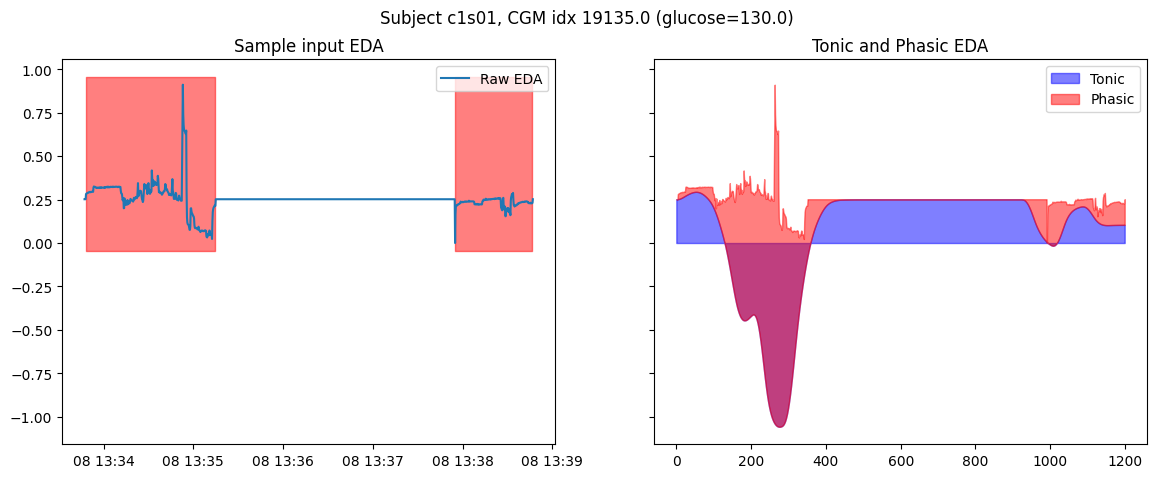

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
_extracted_data = extracted_eda.iloc[0]
raw_eda = _extracted_data['phasic'] + _extracted_data['tonic']
tonicdata = _extracted_data['tonic']
phasicdata = _extracted_data['phasic']

axs[0].plot(uniform_timeline, raw_eda, label='Raw EDA')
axs[0].legend()
axs[0].set_title('Sample input EDA')
yaxis_lim = axs[0].get_ylim()
for seg in _extracted_data['segments']:
    axs[0].fill_betweenx(yaxis_lim, seg[0], seg[1], color='red', alpha=0.5)

axs[1].fill_between(np.arange(tonicdata.shape[0]), tonicdata, color='blue', alpha=0.5, label='Tonic')
axs[1].fill_between(np.arange(phasicdata.shape[0]), tonicdata, raw_eda, color='red', alpha=0.5, label='Phasic')
axs[1].legend()
axs[1].set_title('Tonic and Phasic EDA')

fig.suptitle('Subject {}, CGM idx {} (glucose={})'.format(subject_id, cgm_idx, cgm_glucose))
plt.show()

## Temperature

In [15]:
temp_data = cgm_data['e4']['TEMP']
extracted_temp = [{
    'temp': temp_data['TEMP'].mean(),
    'start_t': temp_data['Time'][0],
    'end_t': temp_data['Time'][-1],
    'glucose': cgm_glucose,
    'CGM_idx': cgm_idx,
    'Timestamp': cgm_timestamp,
}]
extracted_temp = pd.DataFrame(extracted_temp)

print(extracted_temp)


       temp                 start_t                   end_t  glucose  CGM_idx  \
0  31.88517 2022-06-08 13:33:48.250 2022-06-08 13:38:46.750    130.0  19135.0   

            Timestamp  
0 2022-06-08 13:38:47  
